Yue write the code at 2023/07/29

The aim is to test the output torque and callibration the torque constant with a load_Cell-based test system

A double check about the unkown resitance force discovered in spring-based torque test


In [1]:
## connection and calibration
import odrive
from odrive.enums import *
import time
import math
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from IPython.display import clear_output
import numpy as np
import serial


def check(my_drive):
    if my_drive.axis1.error == 0:
        print('Everything is fine')
    else:
        print('Error!')


def lowpass_filter(data,cutoff,fs,order):
    b,a=butter(order,2*cutoff/fs,btype='low',analog=False)
    y=filtfilt(b,a,data)
    return y 

In [2]:
# Find a connected ODrive (this will block until you connect one)
print("finding an odrive...")
my_drive = odrive.find_any()
print("Found! and the bus voltage is " + str(my_drive.vbus_voltage) + "V")
print(my_drive.axis1.motor.current_control.i_gain)
my_drive.axis1.motor.current_control.i_gain = 4
print(my_drive.axis1.motor.current_control.i_gain)

# calibration and enter closed control mode
# print("starting calibration...")
# my_drive.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
# while my_drive.axis1.current_state != AXIS_STATE_IDLE:
#     time.sleep(0.1)
# check(my_drive)
# my_drive.axis1.motor.config.pre_calibrated = True
# my_drive.axis1.encoder.config.pre_calibrated =True
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.controller.input_torque = 0
check(my_drive)
print('*'*50)


finding an odrive...
Found! and the bus voltage is 19.639673233032227V
82.6633529663086
4.0
Everything is fine
**************************************************


In [3]:
# get the load_Cell initail value

ser = serial.Serial(  # 下面这些参数根据情况修改
  port='COM7',# 串口
  baudrate=57600,# 波特率
  parity=serial.PARITY_ODD,
  stopbits=serial.STOPBITS_TWO,
  bytesize=serial.SEVENBITS
)

my_drive.axis1.controller.config.control_mode = 3
my_drive.axis1.controller.input_pos=94/360
time.sleep(1)

#read the initial value of now
t0=time.monotonic()
delta=0
while delta<5:
  delta=time.monotonic()-t0
  data = ser.readline()
#   clear_output()
  try:
    print(int(data))
    cell_ini=int(data)
  except:
    print(data)

print('initial value of load cell',cell_ini)

b'HX711 not found.\r\n'
b'HX711 not found.\r\n'
b'HX711 not found.\r\n'
b'HX711 not found.\r\n'
b'HX711 not found.\r\n'
-30603
-30620
-30617
-30679
-30666
-30603
-30636
-30622
-30658
-30684
-30687
-30666
-30624
-30635
-30619
-30647
-30672
-30645
-30632
-30623
-30651
-30659
-30664
-30661
-30654
-30658
-30693
-30658
-30619
-30627
-30686
-30693
-30669
-30702
-30730
-30669
-30690
-30663
-30702
-30710
-30675
initial value of load cell -30675


In [6]:
t00=time.monotonic()
t0=time.monotonic()


my_drive.axis1.controller.config.control_mode = 1

circle_num=0
add_num=0
sample_num=0

all_cur=[]
all_tor=[]
all_time=[]
all_input=[]

cell_flag=0

stable_tor=[]
stable_input=[]
stable_pos=[]

dif_cur_ini=[0]
desired_cur=dif_cur_ini[0]

cur_dif_ini=[]
tor_dif_ini=[]
time_dif_ini=[]
input_dif_ini=[]

K=9.72e-6#unit: N
ARM=35#unit:mm

while True:

    sample_num+=1
    delta=time.monotonic()-t0
    my_drive.axis1.controller.input_torque=desired_cur
    current=my_drive.axis1.motor.current_control.Iq_measured
    now_position=my_drive.axis1.encoder.pos_circular
    now_position=now_position*360
    
    all_time.append(time.monotonic()-t00)
    all_cur.append(current)
    all_input.append(desired_cur)
    
    #read the load cell
    load_cell = ser.readline() #will stuck here until receive data--so its frequency determine the whole test system frequency
    
    try:
        int(load_cell)
        
        torque=abs((int(load_cell)-cell_ini))*K*ARM #unit: N*mm
    except:
        torque=0
    all_tor.append(torque)

    #display the measurement
    if sample_num%5==0:
        clear_output()
        print('CURRENT: {:.2f}  \nPOSITION: {:.2f} \nTORQUR: {:.2f} \nINPUT: {:.2f}'.format(current,now_position,torque,desired_cur))

    #add current per one sec
    if delta>1:
        t0=time.monotonic()
        desired_cur+=0.1
        add_num+=1
        stable_tor.append(torque)
        stable_input.append(desired_cur)
        stable_pos.append(now_position)
       
    #finish the test circle of one initial torque value
    if desired_cur>18:
        my_drive.axis1.controller.input_torque = 0

        cur_dif_ini.append(all_cur)
        tor_dif_ini.append(all_tor)
        time_dif_ini.append(all_time)
        input_dif_ini.append(all_input)
        
        add_num=0
        circle_num+=1
        try:
            desired_cur=dif_cur_ini[circle_num]
        except:
            break

        clear_output()
        print('Finish the test circle with {} A/10 initial current'.format(dif_cur_ini[circle_num-1]))
        print('Begin the test circle with {} A/10 initial current'.format(dif_cur_ini[circle_num]))
        
        all_cur=[]
        all_angle=[]
        all_time=[]
        all_input=[]

        time.sleep(2)
    
my_drive.axis1.controller.input_torque = 0
check(my_drive)
        

CURRENT: 17.73  
POSITION: 108.68 
TORQUR: 61.77 
INPUT: 18.00
Everything is fine


In [7]:
my_drive.axis1.controller.input_torque = 0
check(my_drive)

Everything is fine


In [8]:
print(len(all_input)/255)
print(len(stable_input)/255)


8.466666666666667
0.7098039215686275


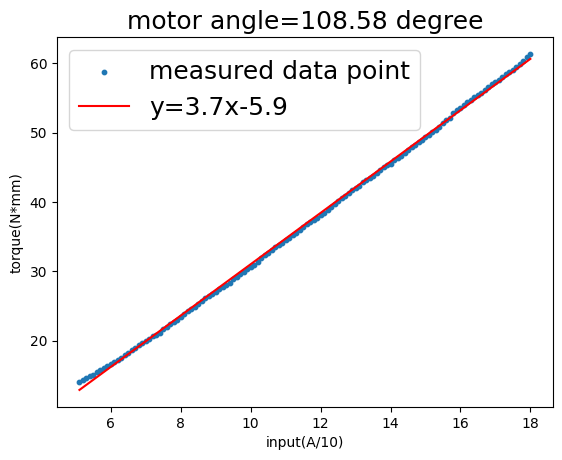

In [10]:

valid_input=[]
valid_tor=[]

# for i in range(400,len(all_input)):
#     if all_tor[i]>10 and all_tor[i]<100:
#         valid_input.append(all_input[i])
#         valid_tor.append(all_tor[i])


valid_input=stable_input[50:-1]
valid_tor=stable_tor[50:-1]


plt.scatter(valid_input,valid_tor,s=10,label='measured data point')

x=np.array(valid_input)
y=np.array(valid_tor)
parameter = np.polyfit(x, y, 1)
expression='y={:.1f}x{:.1f}'.format(parameter[0],parameter[1])
y2=parameter[0]*x+parameter[1]
plt.plot(x,y2,'r',label=expression)
plt.title('motor angle={:.2f} degree'.format(stable_pos[-10]),fontsize=18)
# plt.plot(valid_input,valid_tor)
plt.legend(fontsize=18)
plt.xlabel('input(A/10)')
plt.ylabel('torque(N*mm)')
plt.show()

test the start resistance at different position

# test the start resistance
STEP_INPUT=3
start_cur_seq=[]
start_pos_seq=[]
for i in range(13):
    my_drive.axis1.controller.config.pos_gain=100
    my_drive.axis1.controller.config.control_mode = 3
    my_drive.axis1.controller.input_pos=0.2+i/180
    start_position=(0.2+i/180)*360

    time.sleep(2)
    now_position=my_drive.axis1.encoder.pos_circular
    now_position=now_position*360
    start_pos_seq.append(now_position)
    clear_output()
    print('POSITION INPUT:',start_position)
    print('REAL POSITION',now_position)

    my_drive.axis1.controller.config.control_mode = 1
    my_drive.axis1.controller.input_torque = 0
    t0=time.monotonic()
    delta=0
    current = []
    id=[]
    time_seq=[]
    current_setpoint=[]
    while delta<2:
        delta=time.monotonic()-t0
        time_seq.append(delta)
        current.append(my_drive.axis1.motor.current_control.Iq_measured)
        id.append(my_drive.axis1.motor.current_control.Id_measured)
        current_setpoint.append(my_drive.axis1.motor.current_control.Iq_setpoint)
        if delta>1 and delta<1.1:
            my_drive.axis1.controller.input_torque=STEP_INPUT
            clear_output()
            print('POSITION INPUT:',start_position)
            print('REAL POSITION',now_position)
            print('STEP INPUT CURRENT:{}A'.format(STEP_INPUT))


        # load_cell = ser.readline() #will stuck here until receive data--so its frequency determine the whole test system frequency
        # try:
        #     int(load_cell)
        #     torque=(int(load_cell)-cell_ini)*K*ARM #unit: N*mm
        # except:
        #     torque=0
        # if torque>5:
        #     break

    my_drive.axis1.controller.input_torque = 0

# fs=len(time_seq)/8
# cutoff=3
# print('sample frequency is',fs)
# y = lowpass_filter(current,cutoff,fs,4)
# y2=lowpass_filter(id,cutoff,fs,4)
    
# plt.plot(time_seq,y,label='measured')
# plt.plot(time_seq,current_setpoint,label='setpoint')
# plt.legend()
# plt.show()
